<a href="#top">top</a>

# Import plotting utility

In [32]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Download and load data

In [2]:
#download data
import time
import urllib
import os.path
import sys
versionName = sys.version_info
if versionName[0] == 2:
    import urllib as U
elif versionName[0] == 3:
    import urllib.request as U
start = time.time()
print("Should take at most 30 seconds")
if not os.path.isfile('train_data.pgz'):
    U.urlretrieve("https://sakai.unc.edu/access/content/group/c4f84923-328b-429b-a8dc-a340b0284e41/HW1/train_data.pgz", "train_data.pgz")
if not os.path.isfile('test_data.pgz'):
    U.urlretrieve("https://sakai.unc.edu/access/content/group/c4f84923-328b-429b-a8dc-a340b0284e41/HW1/test_data.pgz", "test_data.pgz")
if not os.path.isfile('vocab_list.pgz'):
    U.urlretrieve( "https://sakai.unc.edu/access/content/group/c4f84923-328b-429b-a8dc-a340b0284e41/HW1/vocab_list.pgz", "vocab_list.pgz" );
end = time.time()
print("Time elapsed (seconds):", end-start)

Should take at most 30 seconds
Time elapsed (seconds): 0.0


In [3]:
#load data
import gzip
import numpy as np
try:
    import cPickle as pickle
    kwargs = {}
except:
    import _pickle as pickle
    kwargs = {'encoding':'bytes'}
    

start = time.time()
print("Should take about 15 seconds")
train_data, train_label = pickle.load( gzip.open( 'train_data.pgz', 'rb' ), **kwargs )
train_label = np.asarray(train_label)
test_data = pickle.load( gzip.open( "test_data.pgz", "rb" ),**kwargs )
vocab_list = pickle.load( gzip.open( "vocab_list.pgz", "rb" ),**kwargs )
end = time.time()
print("Time elapsed (seconds):", end-start)

Should take about 15 seconds
Time elapsed (seconds): 8.349630355834961


In [4]:
#Consider using small set of the data
trainData = train_data[:10000, :]
validData = train_data[10000:15000, :]
trainLabel = train_label[:10000]
validLabel = train_label[10000:15000]
testData = test_data[:10000, :]
print( vocab_list )

['able', 'absolutely', 'across', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'actually', 'add', 'admit', 'adult', 'adventure', 'age', 'ago', 'agree', 'air', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'amazing', 'america', 'american', 'among', 'amusing', 'animated', 'animation', 'annoying', 'another', 'anyone', 'anything', 'anyway', 'apart', 'apparently', 'appear', 'appears', 'appreciate', 'around', 'art', 'ask', 'atmosphere', 'attempt', 'attempts', 'attention', 'audience', 'average', 'avoid', 'away', 'awful', 'baby', 'back', 'background', 'bad', 'badly', 'band', 'based', 'basic', 'basically', 'battle', 'beautiful', 'beauty', 'became', 'become', 'becomes', 'begin', 'beginning', 'begins', 'behind', 'believable', 'believe', 'ben', 'best', 'better', 'beyond', 'big', 'biggest', 'bill', 'bit', 'bizarre', 'black', 'blood', 'body', 'book', 'books', 'bored', 'boring', 'box', 'boy', 'boys', 'break', 'brilliant', 'bring', 'brings', 'britis

In [8]:
train_data.mean(0)

array([ 1.01049613e-15, -5.65727465e-16,  2.07511563e-15, -1.25034871e-15,
        8.93827234e-16,  2.09658957e-16,  1.24238841e-15,  1.42255097e-16,
        1.64055436e-15, -9.47040224e-16,  2.49471777e-15, -2.77537993e-16,
       -1.35806033e-15, -2.28569386e-16, -4.80685491e-16,  4.10660395e-17,
       -1.47469592e-15, -2.29052333e-16,  1.79992687e-15,  5.72459857e-16,
       -7.98441313e-16, -7.43938244e-17, -1.37430067e-15, -4.51683135e-16,
        5.87072613e-16, -1.25504496e-15,  7.40705275e-16, -1.24832367e-15,
       -2.98550518e-15, -2.53230104e-15, -2.07554862e-15, -1.01518793e-17,
        5.15988363e-16, -3.17301740e-16, -1.22530652e-15,  1.63173031e-15,
       -1.02405640e-15, -4.67292871e-16, -3.91819910e-17, -1.19720900e-15,
        2.47845300e-15, -1.31523681e-16,  6.25703933e-16,  2.51556553e-16,
        1.78223658e-15, -1.40591760e-15,  7.31237293e-16, -8.80038264e-16,
       -8.96323016e-16,  7.37727657e-16,  8.86091200e-16, -1.26235244e-15,
       -4.65816274e-16,  

<div id="top_of_steps"></div>
# Steps
1. <a href="#Implement-logistic-regression-likelihood.">Implement logistic regression likelihood.</a>
2. <a href="#Compute-derivative-of-logistic-regression.">Compute derivative of logistic regression.</a>
3. <a href="#Check-gradient.">Check gradient.</a>
4. <a href="#Tweak-gradient-ascent-code.">Tweak gradient ascent code.</a>
5. <a href="#Report-results-and-analysis.">Report results and analysis.</a>

# Implement logistic regression likelihood.

Data is given as $D = {(\mathbf{x}_i, y_i):, i = 1...n}$, where $y_i \in \{-1, +1\}$, and $\mathbf{x}_i \in R^p$. In this case there are n samples and each sample has p features. <br \>

For logistic regression, 
* We have model parameters: $\mathbf{w} \in R^p$ for weight and a bias term $b$.
* For a sample x and its label y, $p(y|\mathbf{x}, \mathbf{w}, b) = \frac{1}{1+exp\{-y(\mathbf{w} \cdot \mathbf{x} + b)\}}$ 
* We can define $x' = \begin{bmatrix} 1\\ x \end{bmatrix}$, then $ \mathbf{w}' =  \begin{bmatrix} b\\ \mathbf{w} \end{bmatrix}$. Therefore the bias term is included in the weight vector. For notation brevity, we still use notations $x, \mathbf{w}$ as $x', \mathbf{w}'$. This can be implemented by numpy.concatenate function.
* Hence the first entry of the vector $w'$ is bias term and the rest are feature weights. In the code we can use w[0] to access the bias term and w[1:] to access the feature weights.

In [5]:
import numpy as np
#We help you do the concatenate, so the first feature becomes the  bias term
train_data_pad = np.concatenate( ( np.ones((trainData.shape[0], 1)), trainData ), axis = 1 )
test_data_pad = np.concatenate( ( np.ones((testData.shape[0], 1)), testData ), axis = 1 )
valid_data_pad = np.concatenate( ( np.ones((validData.shape[0], 1)), validData ), axis = 1 )

## Steps: 
1. Given the data $D = {(\mathbf{x}_i, y_i)} $, write down the likelihood function ($L(\mathbf{w})$) of logistic regression. 
2. Take $\log$ of the likelihood function in (1), write down the log likelihood function. Hint: $\log$ will not cancel $\exp$. 
3. Add  ridge penalty in the log likelihood function (Let the weight of ridge penalty be $\alpha$). 
4. Write a function to compute regularized log likelihood.

1. $ L(\mathbf{w}) =  \prod_{i=1}^{N} \frac{1}{1+exp\{-y_{i}(x \cdot w)\}} $
2. $ LL(\mathbf{w}) = -\sum_{i=1}^{N} (1+exp\{ -y_{i}(x \cdot w)\})$
3. $ PLL(\mathbf{w}) = -\sum_i (1+exp\{ -y_{i}(x \cdot w)\})  - \frac{\alpha}{2}\sum_{j=1}^{p} w_{j}^2 $

In [6]:
import numpy as np
def loglikelihood(w, X, y, alpha): 
    #compute loglikelihood for current w, b, given the data X, y
    #w is a vector, b is a scalr, X is a n*p matrix and y is a vector.
    tmp = 1. + np.exp(-y*(np.dot(X,w.T)))
    return -np.sum(np.log(tmp)) - (alpha/2.)*np.sum(w[1:]**2)

In [7]:
# testing
np.random.seed(1)
X = np.random.randn(2,3)
y = np.array([1,-1])
w = np.ones(3)
w[[1]] = -1;
print(X)
print(y)
loglikelihood(w, X, y, 1)


[[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
[ 1 -1]


-1.1808712118395306

In [8]:
#the values printed in this cell should be the same as the value printed in the previous cell.
print( -np.log(1+np.exp(-1*(X[0,0]-X[0,1]+X[0,2]))) - np.log(1+np.exp(1*(X[1,0]-X[1,1]+X[1,2]))) -1/2.*np.sum(w[1:]**2) )

-1.1808712118395306


<a href="#top_of_steps">top</a>

# Compute derivative of logistic regression.

In order to optimize the function, we want to take the derivative of the function, and update $\mathbf{w}$ according to the direction of the gradient.

In [9]:
import numpy as np
def loglikelihood(w, X, y, alpha): 
    #compute loglikelihood for current w, b, given the data X, y
    #w is a vector, b is a scalr, X is a n*p matrix and y is a vector.
    tmp = 1. + np.exp(-y*(np.dot(X,w.T)))
    prob = 1./tmp
    X = X.T #X becomes a p*n matrix so the gradVal can be compute straight-forwardly.
    gradVal = np.dot(prob * (tmp - 1) * X,y)
    penalty = alpha/2.*np.sum(w[1:]**2)
    gradPenalty = - alpha*w
    gradPenalty[0] = 0;
    return -np.sum( np.log( tmp ) ) - penalty, gradVal + gradPenalty

1. 
$ \frac{\partial PLL(\mathbf{w})}{ \partial w_0} = \sum_i \frac{y_{i} e^{-y_{i}(x_{i} \cdot w)}}{1+e^{-y_{i}(x_{i} \cdot w)}} $ 
$ \frac{\partial PLL(\mathbf{w})}{ \partial w_j} = \sum_i \frac{x_{i,j} y_{i} e^{-y_{i}(x_{i} \cdot w)}}{1+e^{-y_{i}(x_{i} \cdot w)}}  - \alpha w_{j}, j>0$ <br \>
<br \>
2. <br \>
$ \nabla PLL(\mathbf{w}) = \sum_i \frac{ e^{-y_{i}(x_{i} \cdot w)}}{1+e^{-y_{i}(x_{i} \cdot w)}}y_i\begin{bmatrix}  1\\ x_{1,j}\\ \vdots \\x_{i,j}  \end{bmatrix} - \begin{bmatrix}  0\\ \alpha w_{j} \\ \vdots \\ \alpha w_{j}  \end{bmatrix} $

<a href="#top_of_steps">top</a>

# Check gradient.

It is very important we know the derivative we computed is correctly. We can check it by comparing it with numerical answers.

In [10]:
# %load grad_check.py
def grad_check(f,xy0,delta=1e-6,tolerance=1e-7):
    f0,g0 = f(xy0)
    p = len(xy0)
    finite_diff = np.zeros(p)
    gradient_correct = True
    for i in range(p):
        xy1 = np.copy(xy0)
        xy2 = np.copy(xy0)
        xy1[i] = xy1[i] - 0.5*delta
        xy2[i] = xy2[i] + 0.5*delta
        f1,_ = f(xy1)
        f2,_ = f(xy2)
        finite_diff = (f2 - f1)/(delta)
        if (abs(finite_diff - g0[i])>tolerance):
            print("Broken partial",i," Finite Diff: ",finite_diff," Partial: ",g0[i])
            gradient_correct = False
    return gradient_correct

* We initialize the w vector

In [11]:
w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0


The code that tests if the gradient computation is correct

In [12]:
g = lambda xy0: loglikelihood(xy0, X=train_data_pad[:,:15], y=trainLabel, alpha=1)
grad_check( g, w_init[:15], delta=1e-6, tolerance=1e-5 )

True

<a href="#top_of_steps">top</a>

# Tweak gradient ascent code.

Here we provide the gradient ascent function.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
# %load gradient_ascent
def gradient_ascent(f,x,init_step,iterations):  
    f_val,grad = f(x)                           # compute function value and gradient 
    f_vals = [f_val]
    for it in range(iterations):                # iterate for a fixed number of iterations
        #print 'iteration %d' % it
        done = False                            # initial condition for done
        line_search_it = 0                      # how many times we tried to shrink the step
        step = init_step                        # reset step size to the initial size
        while not done and line_search_it<100:  # are we done yet?
            new_x = x + step*grad               # take a step along the gradient
            new_f_val,new_grad = f(new_x)       # evaluate function value and gradient
            if new_f_val<f_val:                 # did we go too far?
                step = step*0.95                # if so, shrink the step-size
                line_search_it += 1             # how many times did we shrank the step
            else:
                done = True                     # better than the last x, so we move on
        
        if not done:                            # did not find right step size
            print("Line Search failed.")
        else:
            f_val = new_f_val                   # ah, we are ok, accept the new x
            x = new_x
            grad = new_grad
            f_vals.append(f_val)
        plt.plot(f_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Function value')
    return f_val, x

In [14]:
np.random.seed(12345)
w_init = np.random.randn( train_data_pad.shape[1] )*0.001
w_init[0] = 0

In [15]:
def optimizeFn( init_step, iterations, alpha, w):
    g = lambda xy0: loglikelihood(xy0, train_data_pad, trainLabel, alpha)
    f_val, update_w = gradient_ascent( g, w, init_step, iterations )
    return f_val, update_w

This should take about 6 seconds.
Time elapsed (seconds): 5.98340916633606
final log-likelihood = -4707.155301



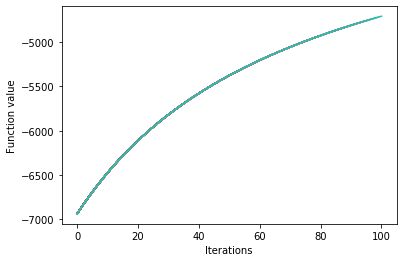

In [16]:
print ('This should take about 6 seconds.')
start = time.time()
f_val, update_w=optimizeFn( init_step = 1e-6, iterations=100, alpha=0, w = w_init) #set init_step to 1e-4, 1e-5, 1e-6
end = time.time()
print ('Time elapsed (seconds):', end-start)
print ('final log-likelihood = %f\n' % (f_val))

Final regularized log-likelihood values for (1e-4, 1e-5, 1e-6) are: -2602.170368, -3033.038249, -4707.155301

<a href="#top_of_steps">top</a>

# Report results and analysis.

To evaluate the results, we need to have a prediction function, that uses the model we trained to predict the comment is positive and negative.

In [17]:
def prediction(w, validData):
    prob = 1./(1+np.exp(-np.dot(validData,w)) );
    res = np.zeros(validData.shape[0])
    res[prob>=0.5] = 1
    res[prob<0.5] = -1
    return res

accuracy on the validation set 84.74%


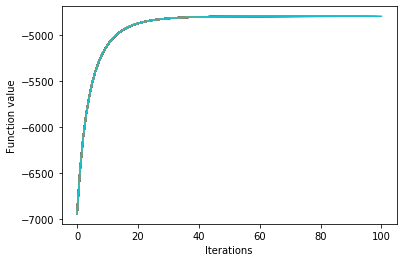

In [18]:
#see the accuracy on the validation set
#when init_step=1e-5, the model has the best accuracy in the validation set
f_val, update_w=optimizeFn( init_step = 1e-5, iterations=100, alpha=3000, w=w_init) #try different alphas [1000, 2000, 3000]
pred = prediction(update_w, valid_data_pad)
print( 'accuracy on the validation set {:.2f}%'.format( 100.*np.mean(pred==validLabel)) )

The best alpha is 3000, and the accuracy of this alpha is: 84.74%

* Report one sample (sample index in the validation data set) that is classified wrong with high probabilites

In [19]:
wrong_idx = np.nonzero( validLabel != pred )[0] #use this command to get the samples that are predicted wrong

In [20]:
#implement the function to compute probability
def computeProb(w, validData ):
    prob = 1./(1+np.exp(-np.dot(validData,w)) )
    return prob

In [32]:
#get the samples that are classified wrong and with probabilites > 0.9
probs = computeProb(update_w, valid_data_pad)
wrong_idx_high = np.argmax(probs) - 1
res = []
for index in wrong_idx:
    if probs[index] >= 0.9:
         print(index)

2027
2257
3204


The sample index is 2027

* Report the words that cause the sample reported in (2) classify wrong.

In [33]:
#Use this function to get the most important words for each sample index
#This function returns a list of top 10 words that influence the prediction.
def getMostImportantFeatures( sampleIdx, validData, update_w, vocab_list ):
    confusedList = []
    intensity = validData[sampleIdx,:]*update_w
    tmp = np.argsort( np.abs(intensity[0,:]) )[::-1]
    for j in np.arange(10):
        confusedList.append(vocab_list[tmp[j]-1])
    return confusedList

In [37]:
confusedList = getMostImportantFeatures( wrong_idx, valid_data_pad, update_w, vocab_list) #use the sample index got from the previous result
confusedList

['poor',
 'unless',
 'season',
 'perfect',
 'brilliant',
 'otherwise',
 'guess',
 'obvious',
 'would',
 'least']